# Objective:
### 1) To find out significant variables required for the prediciton of house prices
### 2) Build a model using the variables

In [95]:
# Importing the libraries
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [96]:
# Reading and viewing the data
data = pd.read_csv("train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [97]:
# Total number of columns are 81
# Checking the value counts in the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [98]:
# Some of the columns have many missing values which will not help in building the model
# Deleting the columns havving more than 30% of missing values
remo_col=[]
for col in data.columns:
    if data[col].isna().sum() > 0.7* len(data):
        data.drop(col,inplace=True,axis=1)
        remo_col.append(col)
print("The number of columns removed are: ",len(remo_col))
print(remo_col)

The number of columns removed are:  4
['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [99]:
# Sorting the data based on data type
cat_data=data.loc[:,(data.dtypes == object).values]
num_data= data.loc[:,~(data.dtypes == object).values]


In [100]:
# Removing columns having a single value occuring more than 90% of times
single_rep_col = []
for col in cat_data:
    if (cat_data[col].value_counts(normalize=True).values)[0]>=0.9:
        single_rep_col.append(col)
        data.drop(col,inplace=True,axis=1)
print("The number of columns removed are: ",len(single_rep_col))
print(single_rep_col)

The number of columns removed are:  13
['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive']


In [101]:
# Checking columns having missing values in data
mis_col=[]
for col in data.columns:
    if not(data[col].isna().sum() == 0):
        mis_col.append(col)
print("The number of columns having missing columns: ",len(mis_col))
print(mis_col)


The number of columns having missing columns:  11
['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish']


<AxesSubplot:>

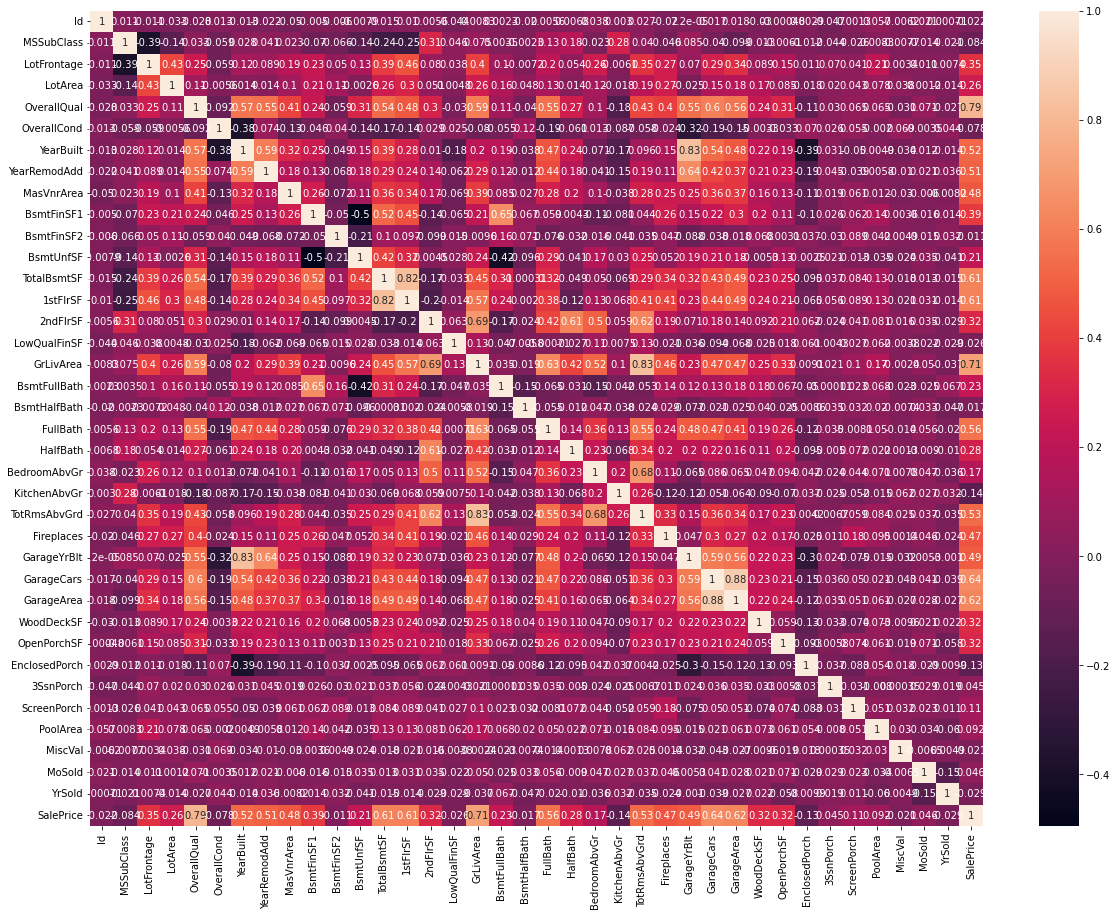

In [104]:
# Plotting corelation matrix between variables
corr_mat = data.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr_mat,annot=True)